<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/SML2020/12_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tree-based methodsによる住宅価格の予測

* California housing datasetという有名なデータセットを使う。

* (scikit-learnからロードできるバージョンは、前処理が済んだキレイなデータなので、ここでは使わない。)

* データの取得や前処理の一部は、
[Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) の2章と同じ。

### 1) データを取得

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

（ここより上の詳細はフォローしなくてもいいいです。）

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2) データを概観しつつ前処理

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# 数値データではない列が一つだけある

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# 今回は、この数値データではない列を残す
# pandasのget_dummiesを使う

housing_num = pd.get_dummies(housing, columns=['ocean_proximity'], drop_first=True)

In [8]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_INLAND      20640 non-null  uint8  
 10  ocean_proximity_ISLAND      20640 non-null  uint8  
 11  ocean_proximity_NEAR BAY    20640 non-null  uint8  
 12  ocean_proximity_NEAR OCEAN  20640 non-null  uint8  
dtypes: float64(9), uint8(4)
memory 

In [9]:
# Non-Null Countが他より少ない列がある
# ここでは単に削除することにする

housing_num = housing_num.dropna(subset=['total_bedrooms'])

In [10]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20433 non-null  float64
 1   latitude                    20433 non-null  float64
 2   housing_median_age          20433 non-null  float64
 3   total_rooms                 20433 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20433 non-null  float64
 6   households                  20433 non-null  float64
 7   median_income               20433 non-null  float64
 8   median_house_value          20433 non-null  float64
 9   ocean_proximity_INLAND      20433 non-null  uint8  
 10  ocean_proximity_ISLAND      20433 non-null  uint8  
 11  ocean_proximity_NEAR BAY    20433 non-null  uint8  
 12  ocean_proximity_NEAR OCEAN  20433 non-null  uint8  
dtypes: float64(9), uint8(4)
memory 

In [11]:
# 説明変数と目的変数を分ける

X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"].copy()

### 3) 評価実験のための準備

In [12]:
# test setを取り除いておく

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4) 訓練データをよくよくながめてみる

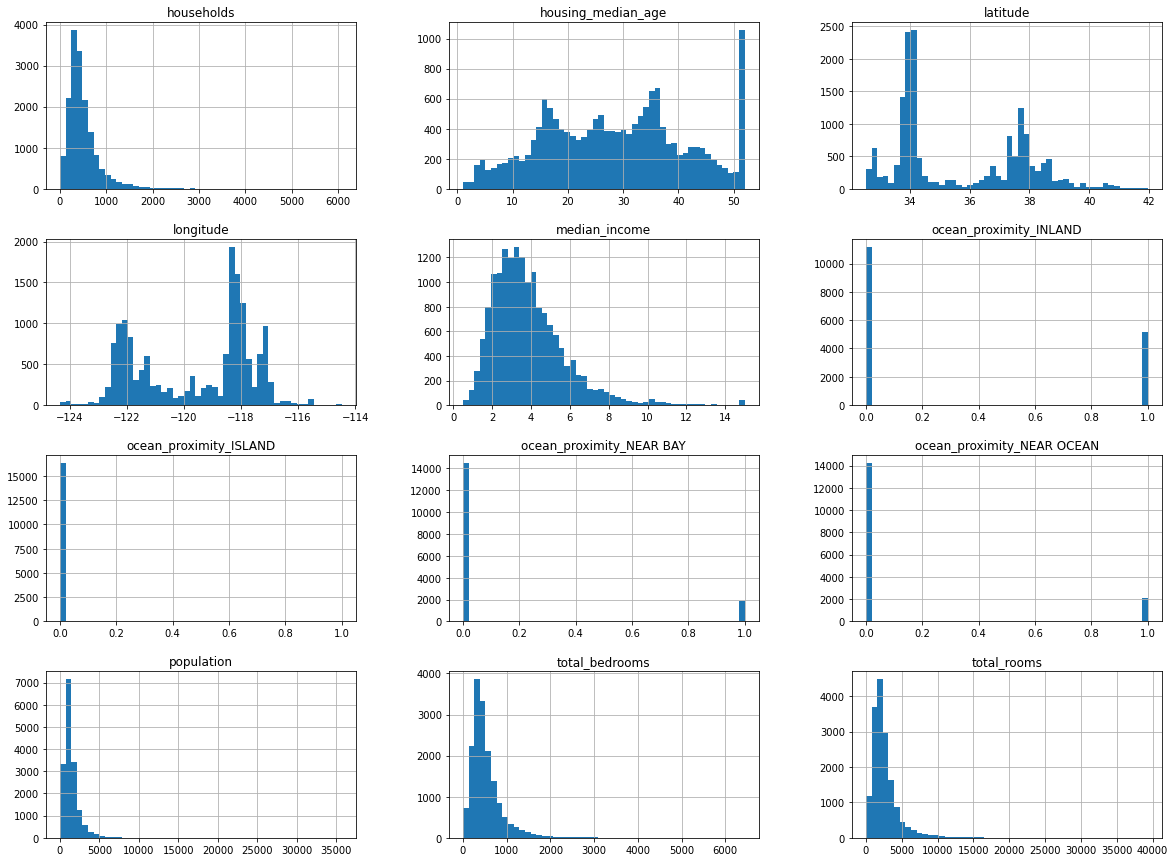

In [13]:
# ヒストグラムを描く
# (cf. Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. p.50)

import matplotlib.pyplot as plt

X_train.hist(bins=50, figsize=(20,15))
plt.show()

### 5) 交差検証で決定木をチューニング

* 木の深さ（領域を何分割するか）をチューニングする。

In [14]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [15]:
# cross_val_scoreで使える評価尺度一覧をチェックする。
# いずれも、「値が大きいほど良い」という評価尺度になっている。
# 今回はRMSEで評価したいが、これは「値が小さいほど良い」という評価尺度である。
# そこで、一覧の中にある'neg_root_mean_squared_error'に、マイナスをつけたものを、使う。

from sklearn import metrics

sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [16]:
# 木の深さは3から20まで変える。
# 評価尺度は　RMSEとする。

for i in range(3, 20):
    reg = tree.DecisionTreeRegressor(max_depth=i, random_state=123)
    # 10-fold cross validationを実施
    scores = cross_val_score(estimator=reg, X=X_train, y=y_train, 
                             scoring='neg_root_mean_squared_error', cv=10)
    print('depth {}: {:.2f}'.format(i, - scores.mean()))  

depth 3: 75741.38
depth 4: 72844.53
depth 5: 70210.48
depth 6: 67396.51
depth 7: 64844.54
depth 8: 62491.94
depth 9: 61744.87
depth 10: 62067.41
depth 11: 62678.79
depth 12: 63264.24
depth 13: 64255.13
depth 14: 65153.89
depth 15: 66153.35
depth 16: 66812.93
depth 17: 67105.93
depth 18: 68012.51
depth 19: 68081.37


In [17]:
# 最適な木の深さを使って訓練データ全体で学習をやり直し、テストデータで評価。

from sklearn.metrics import mean_squared_error

reg = tree.DecisionTreeRegressor(max_depth=9)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print('Test set RMSE: {:.2f}'.format(mean_squared_error(y_test, y_test_pred, squared=False)))

Test set RMSE: 61594.27


この 61792.11 という値を改善することを試みる。

# 課題12

* RMSEによって評価される予測性能を、良くして下さい
* test setとそれ以外の部分の分割は、変えないでください
 * test set以外の部分をどう使うかは、自由です
 * 交差検証の方法は何でもよい。
* 決定木ベースの方法なら何でもいいです。
* test setでのRMSEによる評価は最後に一回おこなうだけです

In [18]:
# XGBoostを使ってみる

import xgboost as xgb

In [19]:
for i in range(3, 20):
    reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=i, random_state=123)
    # 10-fold cross validationを実施
    scores = cross_val_score(estimator=reg, X=X_train, y=y_train, 
                             scoring='neg_root_mean_squared_error', cv=10)
    print('depth {}: {:.2f}'.format(i, - scores.mean()))  

depth 3: 54853.74
depth 4: 51331.20
depth 5: 49321.37
depth 6: 47946.47
depth 7: 47241.37
depth 8: 46752.65
depth 9: 46805.49
depth 10: 46816.17
depth 11: 47109.71
depth 12: 47668.04
depth 13: 47913.14
depth 14: 48073.61
depth 15: 48299.04
depth 16: 48497.83
depth 17: 48619.75
depth 18: 48559.42
depth 19: 48625.10


In [20]:
# テストセットでの最終評価は自分で書いてください。